<a href="https://colab.research.google.com/github/j-ranasinghe/Spam-E-mail-Detection/blob/main/Spam_E_mail_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

# Importing the dataset

In [2]:
cols = ['capital_run_length_total','capital_run_length_longest','capital_run_length_average','char_freq_#','char_freq_$','char_freq_!','char_freq_[','char_freq_(','char_freq_;','word_freq_conference','word_freq_table','word_freq_edu','word_freq_re','word_freq_project','word_freq_original','word_freq_meeting','word_freq_cs','word_freq_direct','word_freq_pm','word_freq_parts','word_freq_1999','word_freq_technology','word_freq_85','word_freq_415','word_freq_data','word_freq_857','word_freq_telnet','word_freq_labs','word_freq_lab','word_freq_650','word_freq_george','word_freq_hpl','word_freq_hp','word_freq_money','word_freq_000','word_freq_font','word_freq_your','word_freq_credit','word_freq_you','word_freq_email','word_freq_business','word_freq_free','word_freq_addresses','word_freq_report','word_freq_people','word_freq_will','word_freq_receive','word_freq_mail','word_freq_order','word_freq_internet','word_freq_remove','word_freq_over','word_freq_our','word_freq_3d','word_freq_all','word_freq_address','word_freq_make','class']
df = pd.read_csv('spambase.data' , names= cols )
df.head()

,capital_run_length_total,capital_run_length_longest,capital_run_length_average,char_freq_#,char_freq_$,char_freq_!,char_freq_[,char_freq_(,char_freq_;,word_freq_conference,...,word_freq_order,word_freq_internet,word_freq_remove,word_freq_over,word_freq_our,word_freq_3d,word_freq_all,word_freq_address,word_freq_make,class
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [3]:
df.head(20)

,capital_run_length_total,capital_run_length_longest,capital_run_length_average,char_freq_#,char_freq_$,char_freq_!,char_freq_[,char_freq_(,char_freq_;,word_freq_conference,...,word_freq_order,word_freq_internet,word_freq_remove,word_freq_over,word_freq_our,word_freq_3d,word_freq_all,word_freq_address,word_freq_make,class
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.000,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.000,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.010,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.000,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.000,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1
5,0.00,0.00,0.00,0.0,1.85,0.00,0.00,1.85,0.00,0.00,...,0.000,0.223,0.0,0.000,0.000,0.000,3.000,15,54,1
6,0.00,0.00,0.00,0.0,1.92,0.00,0.00,0.00,0.00,0.64,...,0.000,0.054,0.0,0.164,0.054,0.000,1.671,4,112,1
7,0.00,0.00,0.00,0.0,1.88,0.00,0.00,1.88,0.00,0.00,...,0.000,0.206,0.0,0.000,0.000,0.000,2.450,11,49,1
8,0.15,0.00,0.46,0.0,0.61,0.00,0.30,0.00,0.92,0.76,...,0.000,0.271,0.0,0.181,0.203,0.022,9.744,445,1257,1
9,0.06,0.12,0.77,0.0,0.19,0.32,0.38,0.00,0.06,0.00,...,0.040,0.030,0.0,0.244,0.081,0.000,1.729,43,749,1


In [4]:
df.tail(10)

,capital_run_length_total,capital_run_length_longest,capital_run_length_average,char_freq_#,char_freq_$,char_freq_!,char_freq_[,char_freq_(,char_freq_;,word_freq_conference,...,word_freq_order,word_freq_internet,word_freq_remove,word_freq_over,word_freq_our,word_freq_3d,word_freq_all,word_freq_address,word_freq_make,class
4591,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.000,0.000,0.0,0.000,0.0,0.0,1.000,1,8,0
4592,0.00,0.0,1.25,0.0,2.50,0.00,0.0,0.0,0.0,0.0,...,0.000,0.111,0.0,0.000,0.0,0.0,1.285,4,27,0
4593,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.000,0.000,0.0,1.052,0.0,0.0,1.000,1,6,0
4594,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.000,0.630,0.0,0.000,0.0,0.0,1.727,5,19,0
4595,0.00,0.0,1.19,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.000,0.000,0.0,0.000,0.0,0.0,1.000,1,24,0
4596,0.31,0.0,0.62,0.0,0.00,0.31,0.0,0.0,0.0,0.0,...,0.000,0.232,0.0,0.000,0.0,0.0,1.142,3,88,0
4597,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.000,0.000,0.0,0.353,0.0,0.0,1.555,4,14,0
4598,0.30,0.0,0.30,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.102,0.718,0.0,0.000,0.0,0.0,1.404,6,118,0
4599,0.96,0.0,0.00,0.0,0.32,0.00,0.0,0.0,0.0,0.0,...,0.000,0.057,0.0,0.000,0.0,0.0,1.147,5,78,0
4600,0.00,0.0,0.65,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.000,0.000,0.0,0.125,0.0,0.0,1.250,5,40,0


# Data Visualisation

In [5]:
df.dtypes #Check the data type of the attributes


capital_run_length_total      float64
capital_run_length_longest    float64
capital_run_length_average    float64
char_freq_#                   float64
char_freq_$                   float64
char_freq_!                   float64
char_freq_[                   float64
char_freq_(                   float64
char_freq_;                   float64
word_freq_conference          float64
word_freq_table               float64
word_freq_edu                 float64
word_freq_re                  float64
word_freq_project             float64
word_freq_original            float64
word_freq_meeting             float64
word_freq_cs                  float64
word_freq_direct              float64
word_freq_pm                  float64
word_freq_parts               float64
word_freq_1999                float64
word_freq_technology          float64
word_freq_85                  float64
word_freq_415                 float64
word_freq_data                float64
word_freq_857                 float64
word_freq_te

In [6]:
df.shape #Check the shape of the dataset

(4601, 58)

In [7]:
#Check the distribution of the spam vs not-spam 
new_class = pd.Categorical(df["class"])
new_class = new_class.rename_categories(["spam","not_spam"])              

new_class.describe()

,counts,freqs
categories,,
spam,2788,0.605955
not_spam,1813,0.394045


In [8]:
df.describe() #Get the descriptions of each attribute

,capital_run_length_total,capital_run_length_longest,capital_run_length_average,char_freq_#,char_freq_$,char_freq_!,char_freq_[,char_freq_(,char_freq_;,word_freq_conference,...,word_freq_order,word_freq_internet,word_freq_remove,word_freq_over,word_freq_our,word_freq_3d,word_freq_all,word_freq_address,word_freq_make,class
count,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,...,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000
mean,0.104553,0.213015,0.280656,0.065425,0.312223,0.095901,0.114208,0.105295,0.090067,0.239413,...,0.038575,0.139030,0.016976,0.269071,0.075811,0.044238,5.191515,52.172789,283.289285,0.394045
std,0.305358,1.290575,0.504143,1.395151,0.672513,0.273824,0.391441,0.401071,0.278616,0.644755,...,0.243471,0.270355,0.109394,0.815672,0.245882,0.429342,31.729449,194.891310,606.347851,0.488698
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.588000,6.000000,35.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.065000,0.000000,0.000000,0.000000,0.000000,2.276000,15.000000,95.000000,0.000000
75%,0.000000,0.000000,0.420000,0.000000,0.380000,0.000000,0.000000,0.000000,0.000000,0.160000,...,0.000000,0.188000,0.000000,0.315000,0.052000,0.000000,3.706000,43.000000,266.000000,1.000000
max,4.540000,14.280000,5.100000,42.810000,10.000000,5.880000,7.270000,11.110000,5.260000,18.180000,...,4.385000,9.752000,4.081000,32.478000,6.003000,19.829000,1102.500000,9989.000000,15841.000000,1.000000


In [9]:
df.isnull()

,capital_run_length_total,capital_run_length_longest,capital_run_length_average,char_freq_#,char_freq_$,char_freq_!,char_freq_[,char_freq_(,char_freq_;,word_freq_conference,...,word_freq_order,word_freq_internet,word_freq_remove,word_freq_over,word_freq_our,word_freq_3d,word_freq_all,word_freq_address,word_freq_make,class
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4596,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4597,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4598,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4599,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


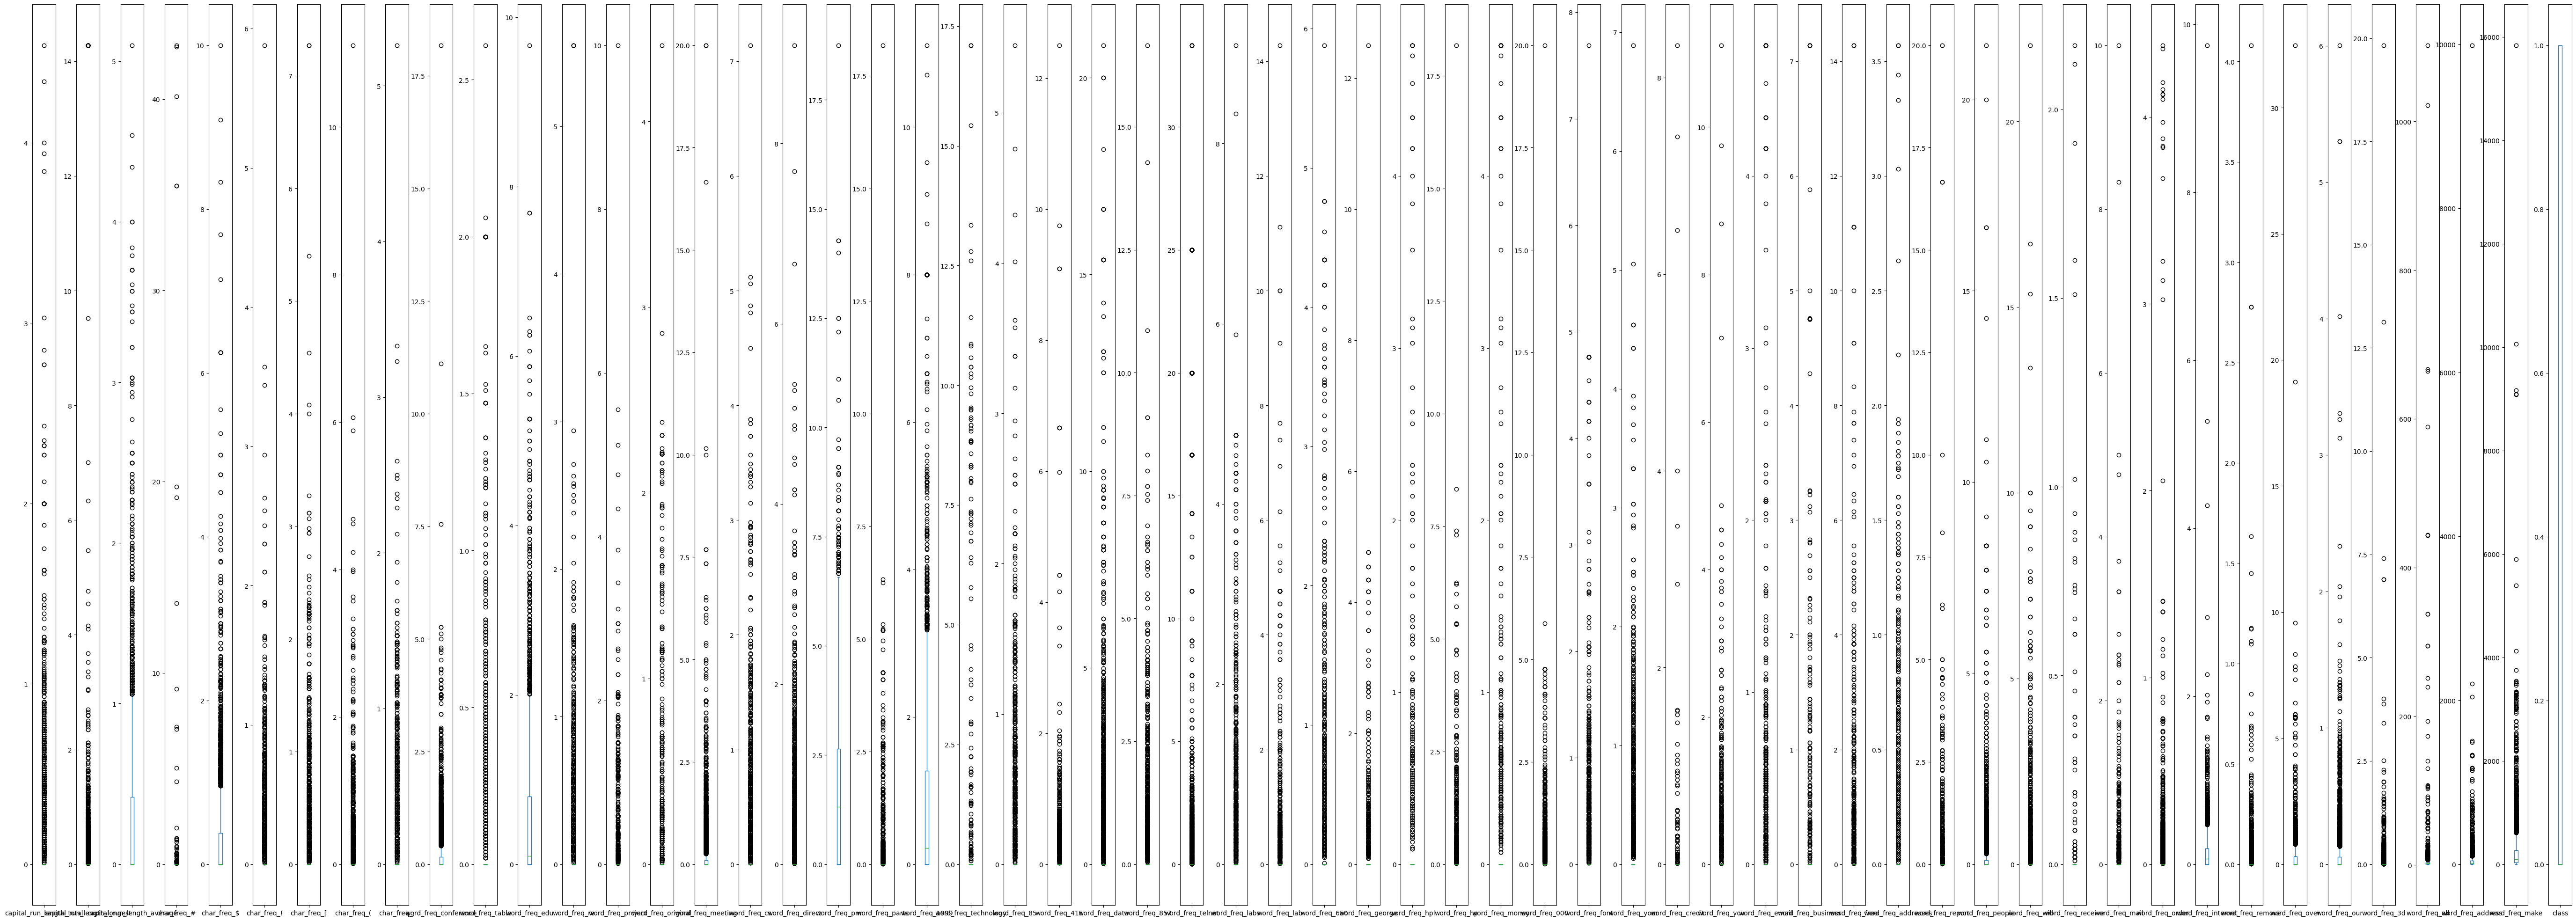

In [10]:
#Boxplot to for outliers
for label in cols[:-1]:
    # for label in range(0,5):
    df.plot(
    kind='box', 
    subplots=True, 
    sharey=False, 
    figsize=(70, 25)
    )
        # increase spacing between subplots
    plt.subplots_adjust(wspace=0.9) 
    plt.show()
    break

#Data Cleaning

In [11]:
selector = VarianceThreshold(0.01) ##Drop unwanted columns using variance as a parameter
dataset1 = selector.fit_transform(df)
scaler = MinMaxScaler() #normalize
dataset2 = scaler.fit_transform(dataset1)

In [12]:
dataset2

array([[0.00000000e+00, 4.48179272e-02, 1.25490196e-01, ...,
        6.00720865e-03, 1.74873737e-02, 1.00000000e+00],
       [4.62555066e-02, 1.96078431e-02, 9.80392157e-02, ...,
        1.00120144e-02, 6.48358586e-02, 1.00000000e+00],
       [1.32158590e-02, 0.00000000e+00, 1.39215686e-01, ...,
        4.84581498e-02, 1.42550505e-01, 1.00000000e+00],
       ...,
       [6.60792952e-02, 0.00000000e+00, 5.88235294e-02, ...,
        5.00600721e-04, 7.38636364e-03, 0.00000000e+00],
       [2.11453744e-01, 0.00000000e+00, 0.00000000e+00, ...,
        4.00480577e-04, 4.86111111e-03, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.27450980e-01, ...,
        4.00480577e-04, 2.46212121e-03, 0.00000000e+00]])

#Split dataset

In [13]:
dataset = pd.DataFrame(dataset2)
train, test = np.split(dataset.sample(frac=1, random_state=42),[int(0.7*len(dataset))])

In [14]:
def scale_dataset(dataframe, oversample = False):
    X = dataframe[dataframe.columns[:-1]].values
    Y = dataframe[dataframe.columns[-1]].values

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    if oversample:
        ros = RandomOverSampler()
        X,Y = ros.fit_resample(X,Y)

    data = np.hstack((X,np.reshape(Y,(-1,1))))

    return data, X,Y

In [15]:
train, X_train, Y_train = scale_dataset(train, oversample=True)
test, X_test, Y_test = scale_dataset(test, oversample=False)

In [16]:
train.shape

(3834, 57)

In [17]:
test.shape

(1381, 57)

In [18]:
dataset.shape

(4601, 57)

In [19]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

In [20]:
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train, Y_train)

KNeighborsClassifier(n_neighbors=3)

In [21]:
KNeighborsClassifier(n_neighbors=3)

KNeighborsClassifier(n_neighbors=3)

In [22]:
Y_pred = knn_model.predict(X_test)

In [23]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

         0.0       0.94      0.86      0.90       871
         1.0       0.79      0.90      0.84       510

    accuracy                           0.87      1381
   macro avg       0.86      0.88      0.87      1381
weighted avg       0.88      0.87      0.88      1381

